<a href="https://colab.research.google.com/github/u270130cfr-cyber/NTT_modeling_KTsuruta/blob/main/NTT_20Days_Modeling_comp_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install japanize-matplotlib
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 43.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=44a6aae904f75ded8231bba8b856e826e3b06660fc3aa9b00f9a38a49e18e171
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [4]:
# NTT株価データ取得
df_price = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_price.csv')
df_price['日付'] = pd.to_datetime(df_price['日付'])
df_price = df_price.sort_values('日付').reset_index(drop=True)

# 自社株買いデータ取得(引用元：NTTプレスリリース)
df_buyback = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ntt_share_buyback_processed.csv')
# Convert relevant date columns to datetime objects
df_buyback['発表日'] = pd.to_datetime(df_buyback['発表日'])
df_buyback['取得開始日'] = pd.to_datetime(df_buyback['取得開始日'])
df_buyback['取得終了日'] = pd.to_datetime(df_buyback['取得終了日'])
# Assign '取得開始日' to a new '日付' column to match the original code's intent for 'df_buyback['日付']'
df_buyback['日付'] = df_buyback['取得開始日']


print(df_price.head())
print(df_price.info())

          日付     終値     始値     高値     安値      出来高   変化率 %
0 1987-02-12  182.4  182.4  182.4  182.4    1.28B  16.25%
1 1987-02-13  172.5  176.5  176.5  172.5  422.38M  -5.43%
2 1987-02-16  175.5  166.7  175.5  165.7  360.51M   1.74%
3 1987-02-17  182.4  176.5  184.3  175.5  881.51M   3.93%
4 1987-02-18  191.2  186.3  191.2  186.3  795.09M   4.82%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547 entries, 0 to 9546
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日付      9547 non-null   datetime64[ns]
 1   終値      9547 non-null   float64       
 2   始値      9547 non-null   float64       
 3   高値      9547 non-null   float64       
 4   安値      9547 non-null   float64       
 5   出来高     9547 non-null   object        
 6   変化率 %   9547 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 522.2+ KB
None


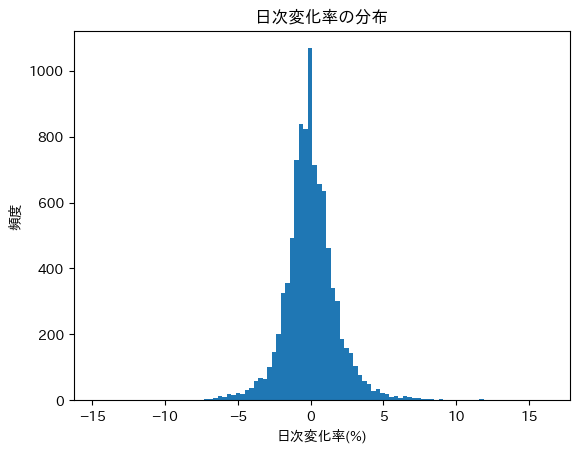

,変化率 %
count,9547.000000
mean,0.017214
std,1.853823
min,-14.740000
25%,-0.930000
50%,0.000000
75%,0.880000
max,16.250000


In [5]:
# Convert '変化率 %' to numeric before plotting and describing
df_price['変化率 %'] = df_price['変化率 %'].str.replace('%', '', regex=False).astype(float)

plt.figure()
plt.hist(df_price['変化率 %'], bins=100)
plt.title('日次変化率の分布')
plt.xlabel('日次変化率(%)')
plt.ylabel('頻度')
plt.show()

df_price['変化率 %'].describe()

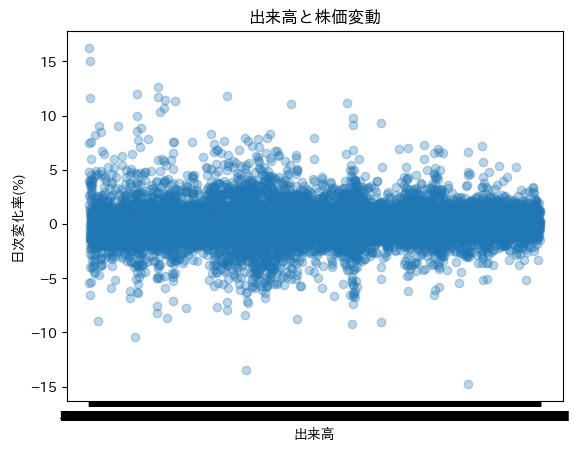

In [6]:
plt.figure()
plt.scatter(df_price['出来高'], df_price['変化率 %'], alpha=0.3)
plt.xlabel('出来高')
plt.ylabel('日次変化率(%)')
plt.title('出来高と株価変動')
plt.show()

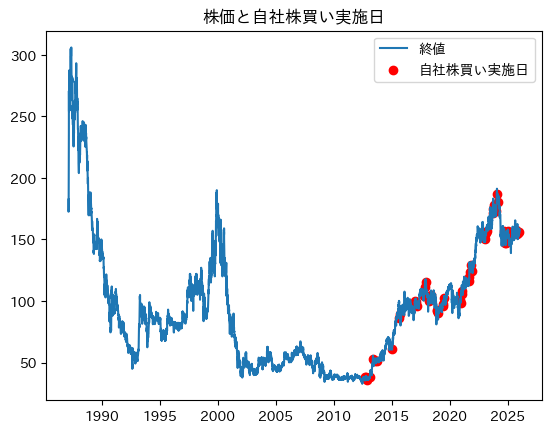

In [7]:
# 株価データにフラグを付与
df_price['buyback_flag'] = df_price['日付'].isin(df_buyback['日付']).astype(int)

plt.figure()
plt.plot(df_price['日付'], df_price['終値'], label='終値')

buyback_days = df_price[df_price['buyback_flag'] == 1]
plt.scatter(buyback_days['日付'], buyback_days['終値'],
            color='red', label='自社株買い実施日')

plt.legend()
plt.title('株価と自社株買い実施日')
plt.show()


In [8]:
df_price['終値'] = pd.to_numeric(df_price['終値'].astype(str).str.replace(',', ''), errors='coerce')

# 出来高が "131.30M" "1.28B" などの文字列を変換
def parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, str):
        v = v.strip().replace(',', '')
        if v.endswith('B'):
            return float(v[:-1]) * 1_000_000_000
        if v.endswith('M'):
            return float(v[:-1]) * 1_000_000
        if v.endswith('K'):
            return float(v[:-1]) * 1_000
        # 末尾が記号でない数値文字列
        try:
            return float(v)
        except:
            return np.nan
    return v

df_price['出来高'] = df_price['出来高'].apply(parse_volume)
df_price['出来高'] = pd.to_numeric(df_price['出来高'], errors='coerce')

In [9]:
# --- 目的変数（Buyラベル）の作成 ---
# 5営業日後の終値（t+5）
df_price['close_t+5'] = df_price['終値'].shift(-5)

# 5営業日後リターン
df_price['ret_5d_future'] = (df_price['close_t+5'] / df_price['終値']) - 1

# ラベル：5営業日後に +1%以上なら Buyすべきだった（1）
df_price['label_buy'] = (df_price['ret_5d_future'] >= 0.01).astype(int)

# --- 日次リターン（ret_1d） ---
df_price['ret_1d'] = df_price['終値'].pct_change()

# --- olling z-score（異常度） ---
# “過去20営業日” を基準に「今日はどれくらい異常か？」を見る
window = 20

ret_mean = df_price['ret_1d'].rolling(window).mean()
ret_std  = df_price['ret_1d'].rolling(window).std()

df_price['ret_1d_z'] = (df_price['ret_1d'] - ret_mean) / ret_std

vol_mean = df_price['出来高'].rolling(window).mean()
vol_std  = df_price['出来高'].rolling(window).std()

df_price['volume_z'] = (df_price['出来高'] - vol_mean) / vol_std

# --- トレンド系特徴量（過去の値動き） ---
# 短期（直近5日）
df_price['ret_5d_past'] = df_price['終値'].pct_change(5)

# 中期（直近20日）
df_price['ret_20d_past'] = df_price['終値'].pct_change(20)


In [10]:
# =========================
# 市場データ（nikkei）追加
# =========================


df_nikkei = yf.download(
    "^N225",
    start=df_price['日付'].min(),
    end=df_price['日付'].max()
).reset_index()

df_nikkei = df_nikkei[['Date', 'Close']] # Changed 'Adj Close' to 'Close'
df_nikkei.columns = ['日付', 'nikkei_close']
df_nikkei['日付'] = pd.to_datetime(df_nikkei['日付'])


print(df_nikkei.head())

# NTT株価と結合
df_mkt = pd.merge(df_price, df_nikkei, on='日付', how='inner')

print("結合後データ件数:", df_mkt.shape)

# 市場（日経平均）リターン
df_mkt['ret_mkt_1d'] = df_mkt['nikkei_close'].pct_change()

# NTT − 市場 の相対リターン
df_mkt['ret_excess_1d'] = df_mkt['ret_1d'] - df_mkt['ret_mkt_1d']

window = 20

df_mkt['ret_excess_z'] = (
    (df_mkt['ret_excess_1d'] - df_mkt['ret_excess_1d'].rolling(window).mean()) /
    df_mkt['ret_excess_1d'].rolling(window).std()
)



/tmp/ipython-input-417259610.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_nikkei = yf.download(
[*********************100%***********************]  1 of 1 completed

          日付  nikkei_close
0 1987-02-12  19874.890625
1 1987-02-13  19628.869141
2 1987-02-16  19531.519531
3 1987-02-17  19637.929688
4 1987-02-18  19881.759766
結合後データ件数: (9543, 17)


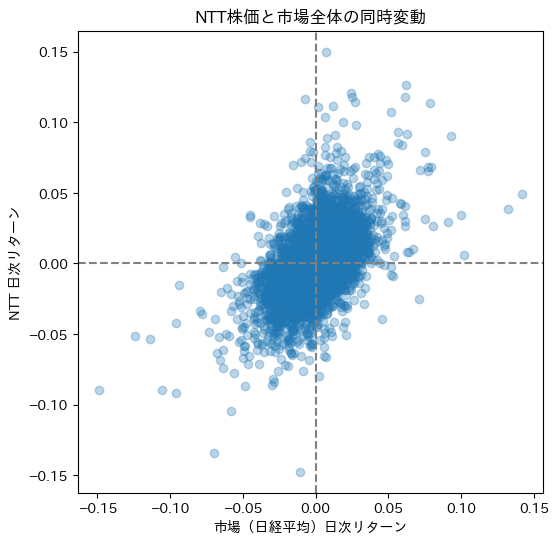

In [12]:
#散布図で同時変動を可視化
plt.figure(figsize=(6,6))
plt.scatter(df_mkt['ret_mkt_1d'], df_mkt['ret_1d'], alpha=0.3)
plt.xlabel('市場（日経平均）日次リターン')
plt.ylabel('NTT 日次リターン')
plt.title('NTT株価と市場全体の同時変動')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


In [ ]:
# --- 自社株買い「取得期間中」フラグの作成 ---
df_price['buyback_in_period'] = 0

for _, r in df_buyback.dropna(subset=['取得開始日', '取得終了日']).iterrows():
    mask = (df_price['日付'] >= r['取得開始日']) & (df_price['日付'] <= r['取得終了日'])
    df_price.loc[mask, 'buyback_in_period'] = 1


# --- 学習用データの整形（欠損除去） ---
feature_cols_v2 = [
    'ret_excess_z',
    'volume_z',
    'ret_5d_past',
    'ret_20d_past'
]
target_col = 'label_buy'

df_model = df_mkt[
    ['日付'] + feature_cols_v2 + [target_col]
].dropna().reset_index(drop=True)

print("df_model shape:", df_model.shape)
display(df_model.head())

df_model shape: (9523, 6)


,日付,ret_excess_z,volume_z,ret_5d_past,ret_20d_past,label_buy
0,1987-03-12,-0.256806,-1.148095,-0.010442,0.558662,0
1,1987-03-13,-0.464942,-1.000488,0.006728,0.648116,0
2,1987-03-16,-0.599588,-1.270019,0.000000,0.597721,0
3,1987-03-17,-0.646533,-1.102118,0.003617,0.521382,0
4,1987-03-18,-0.677803,-0.963124,-0.021041,0.435669,0


label_buy_20d 比率: 0.30231583359530545
df_model_20d shape: (9503, 8)
label_buy_20d 比率: 0.30253604125013156
ret_20d_future 欠損: 0
df_model_20d shape: (9503, 8)
label_buy_20d 比率: 0.30253604125013156
label_buy=1 の比率（上昇日割合）: 0.354


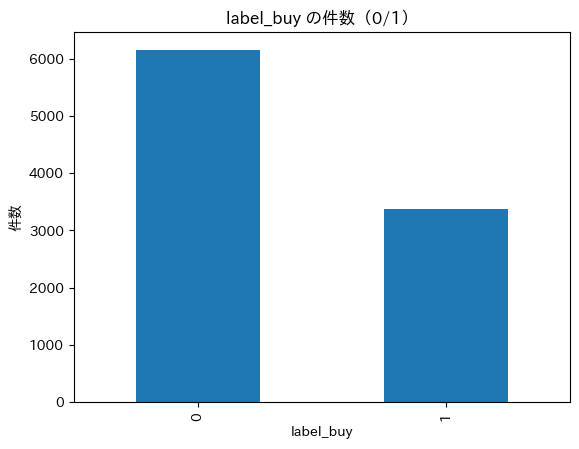

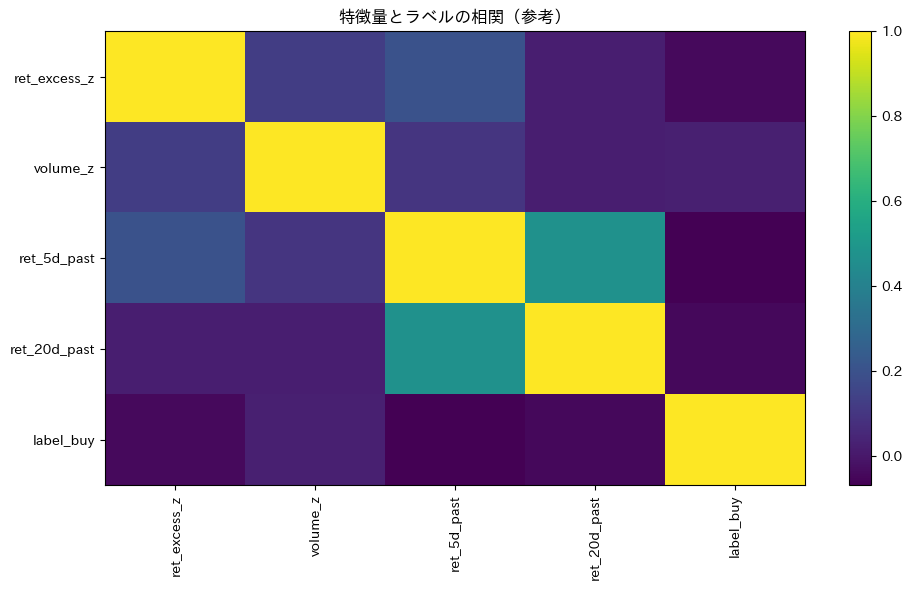

In [ ]:
# =========================
# 20営業日先ラベルの作成
# =========================
df_mkt['close_t+20'] = df_mkt['終値'].shift(-20)
df_mkt['ret_20d_future'] = (df_mkt['close_t+20'] / df_mkt['終値']) - 1
df_mkt['label_buy_20d'] = (df_mkt['ret_20d_future'] >= 0.03).astype(int)

print("label_buy_20d 比率:", df_mkt['label_buy_20d'].mean())


# =========================
# 学習用データ（20日先ラベル）
# =========================
target_col_20d = 'label_buy_20d'

# buyback_in_periodをdf_mktに結合
df_mkt = pd.merge(df_mkt, df_price[['日付', 'buyback_in_period']], on='日付', how='left')

df_model_20d = df_mkt[
    ['日付'] + feature_cols_v2 + [target_col_20d, 'ret_20d_future', 'buyback_in_period']
].dropna().reset_index(drop=True)

print("df_model_20d shape:", df_model_20d.shape)
print("label_buy_20d 比率:", df_model_20d[target_col_20d].mean())
print("ret_20d_future 欠損:", df_model_20d['ret_20d_future'].isna().sum())


print("df_model_20d shape:", df_model_20d.shape)
print("label_buy_20d 比率:", df_model_20d[target_col_20d].mean())


# --- 簡易チェック：ラベルの偏り確認（5日版） ---
label_rate = df_model[target_col].mean()
print(f"label_buy=1 の比率（上昇日割合）: {label_rate:.3f}")

plt.figure()
df_model[target_col].value_counts().sort_index().plot(kind='bar')
plt.title('label_buy の件数（0/1）')
plt.xlabel('label_buy')
plt.ylabel('件数')
plt.show()

# --- 特徴量のざっくり相関を見る（5日版） ---
plt.figure(figsize=(10,6))
corr = df_model[feature_cols_v2 + [target_col]].corr()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title('特徴量とラベルの相関（参考）')
plt.tight_layout()
plt.show()

In [ ]:
# =========================================================
# Walk Forward 検証関数
# =========================================================

def walk_forward_validation(df, features, target,
                            train_window=1000,
                            test_window=20,
                            threshold=0.5):
    results = []

    for start in range(train_window, len(df) - test_window, test_window):
        train = df.iloc[start-train_window:start]
        test  = df.iloc[start:start+test_window]

        X_train = train[features]
        y_train = train[target]
        X_test  = test[features]
        y_test  = test[target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train)

        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        # Precision/Recallは分母0があり得るので安全に処理
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        acc  = accuracy_score(y_test, y_pred)

        # ★AUCは y_test が単一クラスだと定義できない → NaNにして後で除外
        if len(np.unique(y_test)) < 2:
            auc = np.nan
        else:
            auc = roc_auc_score(y_test, y_prob)

        results.append({
            "accuracy": acc,
            "recall": rec,
            "precision": prec,
            "auc": auc
        })

    return pd.DataFrame(results)


In [ ]:
# =========================
# 5営業日先：市場データ版
# =========================
results_excess = walk_forward_validation(
    df_model,
    features=feature_cols_v2,
    target=target_col,
    train_window=1000,
    test_window=20,
    threshold=0.5
)

print("=== 市場データ版（5営業日先）平均指標（AUC定義可能窓のみ） ===")
results_excess_clean = results_excess.dropna(subset=['auc'])
print("有効ウィンドウ数:", len(results_excess_clean))
display(results_excess_clean.mean())


# =========================
# ★20営業日先：
# =========================
results_20d = walk_forward_validation(
    df_model_20d,
    features=feature_cols_v2,
    target=target_col_20d,
    train_window=1000,
    test_window=60,   # ← ここを変更（20→60）
    threshold=0.5
)

print("=== 20営業日先予測 平均指標（AUC定義可能窓のみ） ===")
results_20d_clean = results_20d.dropna(subset=['auc'])
print("有効ウィンドウ数:", len(results_20d_clean))
display(results_20d_clean.mean())

=== 市場データ版（5営業日先）平均指標（AUC定義可能窓のみ） ===
有効ウィンドウ数: 417


,0
accuracy,0.627698
recall,0.068398
precision,0.161153
auc,0.628787


=== 20営業日先予測 平均指標（AUC定義可能窓のみ） ===
有効ウィンドウ数: 136


,0
accuracy,0.683946
recall,0.054950
precision,0.152816
auc,0.622397


In [ ]:
# --- 市場データ版の特徴量 ---
feature_cols_v2 = ['ret_excess_z', 'volume_z', 'ret_5d_past', 'ret_20d_past']
target_col = 'label_buy'

# df_model が市場データ版（df_mkt由来）になっている前提
results_excess = walk_forward_validation(
    df_model,
    features=feature_cols_v2,
    target=target_col,
    train_window=1000,
    test_window=20,
    threshold=0.5
)

print("=== 市場データ版（ret_excess_z）平均指標 ===")
display(results_excess.mean())

=== 市場データ版（ret_excess_z）平均指標 ===


,0
accuracy,0.632277
recall,0.066953
precision,0.157748
auc,0.628787


In [ ]:
# =========================
# Walk Forward 検証（20営業日先）
# =========================

results_20d = walk_forward_validation(
    df_model_20d,
    features=feature_cols_v2,
    target=target_col_20d,
    train_window=1000,
    test_window=20,
    threshold=0.5
)

print("=== 20営業日先予測 平均指標 ===")
display(results_20d.mean())



=== 20営業日先予測 平均指標 ===


,0
accuracy,0.686235
recall,0.042820
precision,0.065548
auc,0.688595


In [ ]:
def backtest_topk(df, features, target, ret_future_col='ret_5d_future',
                  train_window=1000, test_window=20, topk=0.2):
    rows = []

    for start in range(train_window, len(df) - test_window, test_window):
        train = df.iloc[start-train_window:start]
        test  = df.iloc[start:start+test_window].copy()

        X_train = train[features]
        y_train = train[target]
        X_test  = test[features]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train)

        test['prob'] = model.predict_proba(X_test_scaled)[:, 1]

        # 上位k%を「実行日」とする
        n = max(1, int(len(test) * topk))
        exec_days = test.sort_values('prob', ascending=False).head(n)

        rows.append({
            "avg_prob_topk": exec_days['prob'].mean(),
            "avg_ret_topk": exec_days[ret_future_col].mean(),   # 5日後リターン平均
            "exec_rate": n / len(test)
        })

    return pd.DataFrame(rows)


df_model = df_model.merge(df_mkt[['日付','ret_5d_future']], on='日付', how='left').dropna()

bt_top20 = backtest_topk(df_model, feature_cols_v2, target_col, topk=0.2)
bt_top10 = backtest_topk(df_model, feature_cols_v2, target_col, topk=0.1)

print("=== 上位20%戦略 平均 ===")
display(bt_top20.mean())

print("=== 上位10%戦略 平均 ===")
display(bt_top10.mean())


=== 上位20%戦略 平均 ===


,0
avg_prob_topk,0.432454
avg_ret_topk,0.011928
exec_rate,0.200000


=== 上位10%戦略 平均 ===


,0
avg_prob_topk,0.450912
avg_ret_topk,0.015688
exec_rate,0.100000


In [ ]:
#20日モデル・上位10% / 20%
def backtest_topk_20d(df, features, target,
                      ret_future_col='ret_20d_future',
                      train_window=1000,
                      test_window=60,
                      topk=0.2):

    rows = []

    for start in range(train_window, len(df) - test_window, test_window):
        train = df.iloc[start-train_window:start]
        test  = df.iloc[start:start+test_window].copy()

        X_train = train[features]
        y_train = train[target]
        X_test  = test[features]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train)

        test['prob'] = model.predict_proba(X_test_scaled)[:, 1]

        n = max(1, int(len(test) * topk))
        exec_days = test.sort_values('prob', ascending=False).head(n)

        rows.append({
            "avg_prob_topk": exec_days['prob'].mean(),
            "avg_ret_20d": exec_days[ret_future_col].mean(),
            "exec_rate": n / len(test)
        })

    return pd.DataFrame(rows)


In [ ]:
bt20_top10 = backtest_topk_20d(
    df_model_20d,
    feature_cols_v2,
    target_col_20d,
    topk=0.1
)

bt20_top20 = backtest_topk_20d(
    df_model_20d,
    feature_cols_v2,
    target_col_20d,
    topk=0.2
)

print("=== 上位10%戦略（20日）===")
display(bt20_top10.mean())

print("=== 上位20%戦略（20日）===")
display(bt20_top20.mean())

=== 上位10%戦略（20日）===


,0
avg_prob_topk,0.415242
avg_ret_20d,0.028698
exec_rate,0.100000


=== 上位20%戦略（20日）===


,0
avg_prob_topk,0.392046
avg_ret_20d,0.021564
exec_rate,0.200000


In [ ]:
baseline_ret = df_model_20d['ret_20d_future'].mean()
print("全日ベースライン（平均 ret_20d_future）:", baseline_ret)

print("上位10%の平均 ret_20d:", bt20_top10['avg_ret_20d'].mean(), "（改善:", bt20_top10['avg_ret_20d'].mean() - baseline_ret, "）")
print("上位20%の平均 ret_20d:", bt20_top20['avg_ret_20d'].mean(), "（改善:", bt20_top20['avg_ret_20d'].mean() - baseline_ret, "）")


全日ベースライン（平均 ret_20d_future）: 0.001527497558228828
上位10%の平均 ret_20d: 0.028697790631733933 （改善: 0.027170293073505106 ）
上位20%の平均 ret_20d: 0.021563974008719046 （改善: 0.02003647645049022 ）


係数抽出コード（20日モデル）

In [ ]:
X = df_model_20d[feature_cols_v2]
y = df_model_20d[target_col_20d]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y)

coef_df = pd.DataFrame({
    "feature": feature_cols_v2,
    "coef": model.coef_[0]
}).sort_values("coef", ascending=False)

coef_df


,feature,coef
1,volume_z,0.071835
0,ret_excess_z,-0.053767
2,ret_5d_past,-0.079855
3,ret_20d_past,-0.085978


自社株買い日の位置づけ評価（答え合わせ）

In [ ]:
df_eval = df_model_20d.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_eval[feature_cols_v2])

df_eval['buy_score'] = model.predict_proba(X_scaled)[:, 1]


In [ ]:
target_buyback_col = None
if 'buyback_in_period' in df_eval.columns:
    target_buyback_col = 'buyback_in_period'
elif 'buyback_in_period_y' in df_eval.columns:
    target_buyback_col = 'buyback_in_period_y'
else:
    print("Warning: Neither 'buyback_in_period' nor 'buyback_in_period_y' found in df_eval. Buyback days cannot be filtered.")
    buyback_days = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if target_buyback_col:
    buyback_days = df_eval[df_eval[target_buyback_col] == 1]
else:
    buyback_days = pd.DataFrame() # Ensure buyback_days is defined even if no column found

if not buyback_days.empty:
    percentile = buyback_days['buy_score'].rank(pct=True)

    print("自社株買い日の Buyスコア順位（平均）:", percentile.mean())
    print("上位20%に入っている割合:", (percentile >= 0.8).mean())
else:
    print("自社株買い日が検出されませんでした。")

自社株買い日の Buyスコア順位（平均）: 0.5004940711462451
上位20%に入っている割合: 0.20059288537549408


In [ ]:
# =========================================
# 0) 設定
# =========================================
TICKER_NTT = "9432.T"        # NTT（必要に応じて確認）
TICKER_MKT = "^N225"         # 市場代表（日経平均）。TOPIXが取れない場合の代替
TRAIN_WINDOW = 1000          # あなたのWalk Forwardと整合
TOPK_EXEC = 0.10             # 0.10 or 0.20（意思決定ルール）

# 20営業日後に+3%以上をBuy（あなたの20日ラベル）
FUTURE_DAYS = 20
BUY_THRESHOLD = 0.03


In [ ]:
# =========================================
# 1) 最新データ取得（MultiIndexを避ける）
# =========================================
df_ntt = yf.Ticker(TICKER_NTT).history(period="max", auto_adjust=True)
df_mkt = yf.Ticker(TICKER_MKT).history(period="max", auto_adjust=True)

# index(日付)を列に
df_ntt = df_ntt.reset_index().rename(columns={"Date": "日付"})
df_mkt = df_mkt.reset_index().rename(columns={"Date": "日付"})

# 必要列を統一
# NTT側：終値・出来高
df_ntt = df_ntt.rename(columns={"Close": "終値", "Volume": "出来高"})
df_ntt = df_ntt[["日付", "終値", "出来高"]].copy()

# 市場側：終値
df_mkt = df_mkt.rename(columns={"Close": "mkt_close"})
df_mkt = df_mkt[["日付", "mkt_close"]].copy()

# 日付型
df_ntt["日付"] = pd.to_datetime(df_ntt["日付"])
df_mkt["日付"] = pd.to_datetime(df_mkt["日付"])

# 結合
df = pd.merge(df_ntt, df_mkt, on="日付", how="inner").sort_values("日付").reset_index(drop=True)

print("結合後df shape:", df.shape)
print(df.head())

結合後df shape: (6387, 4)
                         日付         終値         出来高     mkt_close
0 2000-01-04 00:00:00+09:00  93.537010  4600000000  19002.859375
1 2000-01-05 00:00:00+09:00  89.879082  6225000000  18542.550781
2 2000-01-06 00:00:00+09:00  87.266304  4375000000  18168.269531
3 2000-01-07 00:00:00+09:00  86.221214  5550000000  18193.410156
4 2000-01-11 00:00:00+09:00  88.834000  5050000000  18850.919922


In [ ]:
# =========================================
# 特徴量作成
# =========================================
# 日次リターン
df["ret_1d"] = df["終値"].pct_change()
df["mkt_ret_1d"] = df["mkt_close"].pct_change()

# 市場超過リターン
df["ret_excess"] = df["ret_1d"] - df["mkt_ret_1d"]

# Zスコア（rollingで“過去のみ”参照にするのが安全）
ROLL = 120  # 過去約半年
df["ret_excess_z"] = (df["ret_excess"] - df["ret_excess"].rolling(ROLL).mean()) / df["ret_excess"].rolling(ROLL).std()
df["volume_z"] = (df["出来高"] - df["出来高"].rolling(ROLL).mean()) / df["出来高"].rolling(ROLL).std()

# 過去5日/20日リターン（pastのみ）
df["ret_5d_past"] = df["終値"].pct_change(5)
df["ret_20d_past"] = df["終値"].pct_change(20)

In [ ]:
# =========================================
# ラベル作成（学習用：20営業日後に+3%以上）
# =========================================
df["close_t+20"] = df["終値"].shift(-FUTURE_DAYS)
df["ret_20d_future"] = (df["close_t+20"] / df["終値"]) - 1
df["label_buy_20d"] = (df["ret_20d_future"] >= BUY_THRESHOLD).astype(int)

# =========================================
# 学習用テーブル
# =========================================
feature_cols_v2 = ["ret_excess_z", "volume_z", "ret_5d_past", "ret_20d_past"]
target_col_20d = "label_buy_20d"

df_model_20d = df[["日付"] + feature_cols_v2 + [target_col_20d]].dropna().reset_index(drop=True)

if len(df_model_20d) < TRAIN_WINDOW + 5:
    raise ValueError(f"データが不足しています。df_model_20d={len(df_model_20d)}行")

# =========================================
# 今日の判定：直近TRAIN_WINDOWで学習→最新日を推論
# =========================================
train = df_model_20d.iloc[-TRAIN_WINDOW:].copy()
today_row = df_model_20d.iloc[[-1]].copy()  # 最新1行

X_train = train[feature_cols_v2]
y_train = train[target_col_20d]
X_today = today_row[feature_cols_v2]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_today_s = scaler.transform(X_today)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_s, y_train)

today_prob = float(model.predict_proba(X_today_s)[:, 1][0])

# 「過去のスコア分布で、今日が何パーセンタイルか」
train_probs = model.predict_proba(X_train_s)[:, 1]
today_percentile = float((train_probs <= today_prob).mean())  # 0〜1

# TopK判定（上位10%/20%に入っているか）
is_topk = today_percentile >= (1.0 - TOPK_EXEC)

# =========================================
# 実務制約を反映
# =========================================
decision = "見送り"
reason = []

if is_topk:
    decision = "実行候補（モデル上位）"
    reason.append(f"Buyスコアが直近{TRAIN_WINDOW}日分布で上位{int(TOPK_EXEC*100)}%以内")
else:
    decision = "見送り"
    reason.append(f"Buyスコアが上位{int(TOPK_EXEC*100)}%に入らず")

In [ ]:
# =========================================
# 出力
# =========================================
print("=== 買付判断基準日 ===")
print("日付:", today_row["日付"].iloc[0].date())

print("=== 買付判断基準日の翌営業日における予想は以下のようになる===")
print("Buyスコア（上昇確率）:", round(today_prob, 4))
print("スコア順位（percentile）:", round(today_percentile, 4), "（1に近いほど上位）")
print("判定:", decision)
print("根拠:", " / ".join(reason))

# 係数（説明用）
coef_df = pd.DataFrame({"feature": feature_cols_v2, "coef": model.coef_[0]}).sort_values("coef", ascending=False)
print("\n=== 係数（説明用） ===")
display(coef_df)


=== 買付判断基準日 ===
日付: 2026-01-29
=== 買付判断基準日の翌営業日における予想は以下のようになる===
Buyスコア（上昇確率）: 0.285
スコア順位（percentile）: 0.827 （1に近いほど上位）
判定: 見送り
根拠: Buyスコアが上位10%に入らず

=== 係数（説明用） ===


,feature,coef
3,ret_20d_past,0.073168
1,volume_z,0.052229
0,ret_excess_z,-0.021095
2,ret_5d_past,-0.128532
